In [218]:
import pandas as pd
import numpy as np
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgboost
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv('../../data/wiki_movie_plots_deduped.csv')

In [4]:
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [5]:
data.shape

(34886, 8)

In [6]:
data.iloc[100]['Wiki Page']

'https://en.wikipedia.org/wiki/Should_a_Woman_Divorce%3F'

In [7]:
data.iloc[100]['Title']

'Should a Woman Divorce?'

In [8]:
data['Genre'].unique()

array(['unknown', 'western', 'comedy', ...,
       'adventure, romance, fantasy film', 'ero',
       'horror romantic comedy'], dtype=object)

In [9]:
data['Genre'].value_counts()

unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2265, dtype: int64

In [10]:
data[data['Genre'].str.contains('action',case=False)].count()

Release Year        2450
Title               2450
Origin/Ethnicity    2450
Director            2450
Cast                2419
Genre               2450
Wiki Page           2450
Plot                2450
dtype: int64

In [11]:
len(data[data['Genre'] == 'tokusatsu, action, sci-fi'])

5

In [12]:
basic_genre = pd.read_excel("../../data/wiki_movie_plots_deduped_basic_genre.xlsx",sheet_name='updated_genre')

In [13]:
genre_list = basic_genre['basic - genre'].str.rstrip().str.lstrip().str.lower()
genre_list

0               action/gangster/fighting
1                 comedy/dramedy/rom com
2                 sci-fi/science fiction
3          romance/love/romantic/rom com
4                              adventure
                     ...                
59              post-apocalyptic, zombie
60                             espionage
61                        counterculture
62    political/socio-political/politics
63                               tragedy
Name: basic - genre, Length: 64, dtype: object

In [14]:
new_genre_list = list(set(itertools.chain.from_iterable(genre_list.str.split('/').tolist()))) #.values.ravel()
new_genre_list = [i.rstrip().lstrip() for i in new_genre_list]

In [15]:
print(new_genre_list)

['anime', 'musical', 'drama', 'history', 'teen', 'anthology', 'educational', 'bio-pic', 'horror', 'martial-arts', 'biography', 'patriotic', 'serial', 'bio-drama', 'superhero', 'music', 'satire', 'social', 'romance', 'art', 'miniseries', 'concert', 'thriller', 'detective', 'suspense', 'samurai', 'crime', 'adult', 'entertainer', 'western', 'muslim social', "children's", 'biopic', 'mythology', 'post-apocalyptic, zombie', 'sword', 'dramedy', 'adventure', 'swashbuckler', 'cartoon', 'devotional', 'classic muslim social', 'survival', 'documentary', 'love', 'science fiction', 'road', 'compilation', 'mystery', 'disaster', 'period film', 'fighting', 'tragedy', 'fantay', 'politics', 'mockumentary', 'romantic', 'short', 'period', 'sports', 'espionage', 'film noir', 'buddy cop', 'historic', 'american football', 'sexploitation', 'animation', 'action', 'outlaw biker film', 'comedy', 'rom com', 'ancient-costume', 'animated', 'exploitation', 'socio-political', 'epic', 'martial arts', 'parody', 'biograp

In [16]:
data.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [17]:
genre_mhe = data.drop(columns = ['Cast','Wiki Page'])
genre_mhe

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,unknown,Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",unknown,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,unknown,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,comedy,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,comedy,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...


In [18]:
for genre in new_genre_list:
    ind = genre_mhe[genre_mhe['Genre'].str.contains(genre,case = False)].index
    genre_mhe.loc[ind,genre] = 1
    

In [19]:
genre_mhe.head(3)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
genre_mhe.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Genre',
       'Plot', 'anime', 'musical', 'drama', 'history',
       ...
       'semi-staged documentary', 'family', 'religious', 'adaptation',
       'sci-fi', 'counterculture', 'neo-noir', 'buddy cop, supernatural',
       'kung fu', 'slapstick'],
      dtype='object', length=111)

In [21]:
nan_ind = genre_mhe[genre_mhe.drop(['Genre','Title','Plot'],axis = 1).isna().all(axis = 1)].index
nan_ind

Int64Index([], dtype='int64')

In [22]:
genre_mhe.loc[nan_ind]

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick


In [23]:
print(new_genre_list)

['anime', 'musical', 'drama', 'history', 'teen', 'anthology', 'educational', 'bio-pic', 'horror', 'martial-arts', 'biography', 'patriotic', 'serial', 'bio-drama', 'superhero', 'music', 'satire', 'social', 'romance', 'art', 'miniseries', 'concert', 'thriller', 'detective', 'suspense', 'samurai', 'crime', 'adult', 'entertainer', 'western', 'muslim social', "children's", 'biopic', 'mythology', 'post-apocalyptic, zombie', 'sword', 'dramedy', 'adventure', 'swashbuckler', 'cartoon', 'devotional', 'classic muslim social', 'survival', 'documentary', 'love', 'science fiction', 'road', 'compilation', 'mystery', 'disaster', 'period film', 'fighting', 'tragedy', 'fantay', 'politics', 'mockumentary', 'romantic', 'short', 'period', 'sports', 'espionage', 'film noir', 'buddy cop', 'historic', 'american football', 'sexploitation', 'animation', 'action', 'outlaw biker film', 'comedy', 'rom com', 'ancient-costume', 'animated', 'exploitation', 'socio-political', 'epic', 'martial arts', 'parody', 'biograp

In [24]:
subset_genre_mhe = genre_mhe.loc[nan_ind]
for genre in new_genre_list:
    ind = subset_genre_mhe[subset_genre_mhe['Title'].str.contains(genre,case = False)].index
    genre_mhe.loc[ind,genre] = 1

In [25]:
genre_mhe

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,unknown,Lasting just 61 seconds and consisting of two ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",unknown,The earliest known adaptation of the classic f...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,unknown,"The film begins in 1919, just after World War ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,comedy,"Two musicians, Salih and Gürkan, described the...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,comedy,"Zafer, a sailor living with his mother Döndü i...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
len(genre_mhe) - genre_mhe['devotional'].isna().sum()

19

In [27]:
nan_ind = genre_mhe[genre_mhe.drop(['Genre','Title','Plot'],axis = 1).isna().all(axis = 1)].index
nan_ind

Int64Index([], dtype='int64')

In [28]:
subset_genre_mhe = genre_mhe.loc[nan_ind]
for genre in new_genre_list:
    ind = subset_genre_mhe[subset_genre_mhe['Plot'].str.contains(genre,case = False)].index
    genre_mhe.loc[ind,genre] = 1

In [29]:
genre_mhe

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,unknown,Lasting just 61 seconds and consisting of two ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",unknown,The earliest known adaptation of the classic f...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,unknown,"The film begins in 1919, just after World War ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,comedy,"Two musicians, Salih and Gürkan, described the...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,comedy,"Zafer, a sailor living with his mother Döndü i...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
genre_mhe.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
basic_genre['basic - genre']

0               action/gangster/fighting
1                 comedy/dramedy/rom com
2                 sci-fi/science fiction
3          romance/love/romantic/rom com
4                              adventure
                     ...                
59              post-apocalyptic, zombie
60                             espionage
61                        counterculture
62    political/socio-political/politics
63                               tragedy
Name: basic - genre, Length: 64, dtype: object

In [32]:
raw_basic_genre = {}
single_genre =[]
for val in basic_genre['basic - genre']:
    temp = [i.rstrip().lstrip() for i in val.split('/')]
    if len(temp) > 1:
        raw_basic_genre[temp[0]] = temp[1:]
    else:
        single_genre.append(temp[0])
print(raw_basic_genre)

{'action': ['gangster', 'fighting'], 'comedy': ['dramedy', 'rom com'], 'sci-fi': ['science fiction'], 'romance': ['love', 'romantic', 'rom com'], 'drama': ['dramedy'], 'kung fu': ['martial arts', 'martial-arts'], 'suspense': ['thriller', 'mystery'], 'history': ['historical', 'period film', 'historic', 'period', 'sword'], 'fantasy': ['fantay'], 'biography': ['bio-pic', 'biopic', 'bio-drama', 'biographical'], 'costume': ['ancient-costume'], 'spy': ['detective'], 'children': ["children's"], 'musical': ['music', 'concert'], 'sports': ['american football'], 'animated': ['animation'], 'patriotic': ['independent'], 'devotional': ['mythology', 'religious'], 'documentary': ['semi-staged documentary', 'mockumentary', 'nature documentary'], 'film noir': ['neo-noir'], 'exploitation': ['sexploitation'], 'social': ['muslim social', 'classic muslim social'], 'buddy cop': ['buddy cop, supernatural'], 'political': ['socio-political', 'politics']}


In [33]:
print(single_genre)

['adventure', 'crime', 'war', 'horror', 'superhero', 'family', 'entertainer', 'epic', 'western', 'road', 'samurai', 'parody', 'adaptation', 'adult', 'serial', 'disaster', 'short', 'anime', 'anthology', 'art', 'cartoon', 'miniseries', 'swashbuckler', 'educational', 'slapstick', 'compilation', 'travel', 'outlaw biker film', 'teen', 'shakespearean', 'satire', 'reality', 'dance', 'spoof', 'survival', 'slahser', 'post-apocalyptic, zombie', 'espionage', 'counterculture', 'tragedy']


In [34]:
genre_mhe_test = genre_mhe.fillna(0)

In [35]:
raw_basic_genre

{'action': ['gangster', 'fighting'],
 'comedy': ['dramedy', 'rom com'],
 'sci-fi': ['science fiction'],
 'romance': ['love', 'romantic', 'rom com'],
 'drama': ['dramedy'],
 'kung fu': ['martial arts', 'martial-arts'],
 'suspense': ['thriller', 'mystery'],
 'history': ['historical', 'period film', 'historic', 'period', 'sword'],
 'fantasy': ['fantay'],
 'biography': ['bio-pic', 'biopic', 'bio-drama', 'biographical'],
 'costume': ['ancient-costume'],
 'spy': ['detective'],
 'children': ["children's"],
 'musical': ['music', 'concert'],
 'sports': ['american football'],
 'animated': ['animation'],
 'patriotic': ['independent'],
 'devotional': ['mythology', 'religious'],
 'documentary': ['semi-staged documentary',
  'mockumentary',
  'nature documentary'],
 'film noir': ['neo-noir'],
 'exploitation': ['sexploitation'],
 'social': ['muslim social', 'classic muslim social'],
 'buddy cop': ['buddy cop, supernatural'],
 'political': ['socio-political', 'politics']}

In [36]:
def col_merge(df_genre):
    df = df_genre.copy()
    for key,lst in raw_basic_genre.items():
        lst_copy = lst + [key]
        print(lst_copy)
#         display(df[lst_copy])
        df[key] = df[lst_copy].sum(axis = 1)
#         display(df[lst_copy].sum(axis = 1))
#         df = df.drop(columns = lst)
    return df
        

In [37]:
print('adventure' in genre_mhe_test.columns )

True


In [38]:
result_tags = col_merge(genre_mhe_test)
result_tags.head(2)

['gangster', 'fighting', 'action']
['dramedy', 'rom com', 'comedy']
['science fiction', 'sci-fi']
['love', 'romantic', 'rom com', 'romance']
['dramedy', 'drama']
['martial arts', 'martial-arts', 'kung fu']
['thriller', 'mystery', 'suspense']
['historical', 'period film', 'historic', 'period', 'sword', 'history']
['fantay', 'fantasy']
['bio-pic', 'biopic', 'bio-drama', 'biographical', 'biography']
['ancient-costume', 'costume']
['detective', 'spy']
["children's", 'children']
['music', 'concert', 'musical']
['american football', 'sports']
['animation', 'animated']
['independent', 'patriotic']
['mythology', 'religious', 'devotional']
['semi-staged documentary', 'mockumentary', 'nature documentary', 'documentary']
['neo-noir', 'film noir']
['sexploitation', 'exploitation']
['muslim social', 'classic muslim social', 'social']
['buddy cop, supernatural', 'buddy cop']
['socio-political', 'politics', 'political']


,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
result_tags.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,anime,musical,drama,history,...,semi-staged documentary,family,religious,adaptation,sci-fi,counterculture,neo-noir,"buddy cop, supernatural",kung fu,slapstick
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
lst_tags = list(raw_basic_genre.keys()) +  single_genre 

In [41]:
seg_cols = ['Release Year','Title','Origin/Ethnicity','Director','Genre','Plot']

In [42]:
result_tags = result_tags[ seg_cols + lst_tags ] 
result_tags

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,action,comedy,sci-fi,romance,...,satire,reality,dance,spoof,survival,slahser,"post-apocalyptic, zombie",espionage,counterculture,tragedy
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,unknown,Lasting just 61 seconds and consisting of two ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",unknown,The earliest known adaptation of the classic f...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,unknown,"The film begins in 1919, just after World War ...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,comedy,"Two musicians, Salih and Gürkan, described the...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,comedy,"Zafer, a sailor living with his mother Döndü i...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
genre_mhe.iloc[32100].dropna()

Release Year                                                     2001
Title                                                  Sri Manjunatha
Origin/Ethnicity                                               Telugu
Director                                            K Raghavendra Rao
Genre                                                      devotional
Plot                Manjunatha (Arjun Sarja) is an atheist, but a ...
devotional                                                        1.0
Name: 32100, dtype: object

In [44]:
genre_mhe.iloc[24572].dropna()

Release Year                                                          1963
Title                                                         Mere Mehboob
Origin/Ethnicity                                                 Bollywood
Director                                                      H. S. Rawail
Genre                                                classic muslim social
Plot                     While studying in Aligarh Muslim University, A...
social                                                                 1.0
muslim social                                                          1.0
classic muslim social                                                  1.0
Name: 24572, dtype: object

#### Label/Tags EDA

In [45]:
result_tags.head(3)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,action,comedy,sci-fi,romance,...,satire,reality,dance,spoof,survival,slahser,"post-apocalyptic, zombie",espionage,counterculture,tragedy
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
result_tags[result_tags['action'] > 0 ]['action'].count()

2464

In [47]:
col_count_per = pd.DataFrame()

In [48]:
counts = []
for col in lst_tags:
    count = result_tags[result_tags[col] > 0][col].count()
    counts.append(count)
#     print(col,count,round(count/len(result_tags)*100,2))
    
col_count_per['tags'] = lst_tags
col_count_per['count'] = counts
# col_count_per['percentage'] = /len

In [49]:
col_count_per['percentage'] = col_count_per['count']/len(result_tags) *100

In [50]:
col_count_per.sort_values('count',ascending=False)

,tags,count,percentage
4,drama,9508,27.254486
1,comedy,7314,20.965430
3,romance,2647,7.587571
0,action,2464,7.063005
6,suspense,2345,6.721894
...,...,...,...
58,survival,1,0.002866
59,slahser,1,0.002866
60,"post-apocalyptic, zombie",1,0.002866
30,entertainer,1,0.002866


In [51]:
col_count_per.describe()

,count,percentage
count,64.000000,64.000000
mean,576.125000,1.651450
std,1554.157328,4.454960
min,1.000000,0.002866
25%,4.750000,0.013616
50%,43.500000,0.124692
75%,381.750000,1.094279
max,9508.000000,27.254486


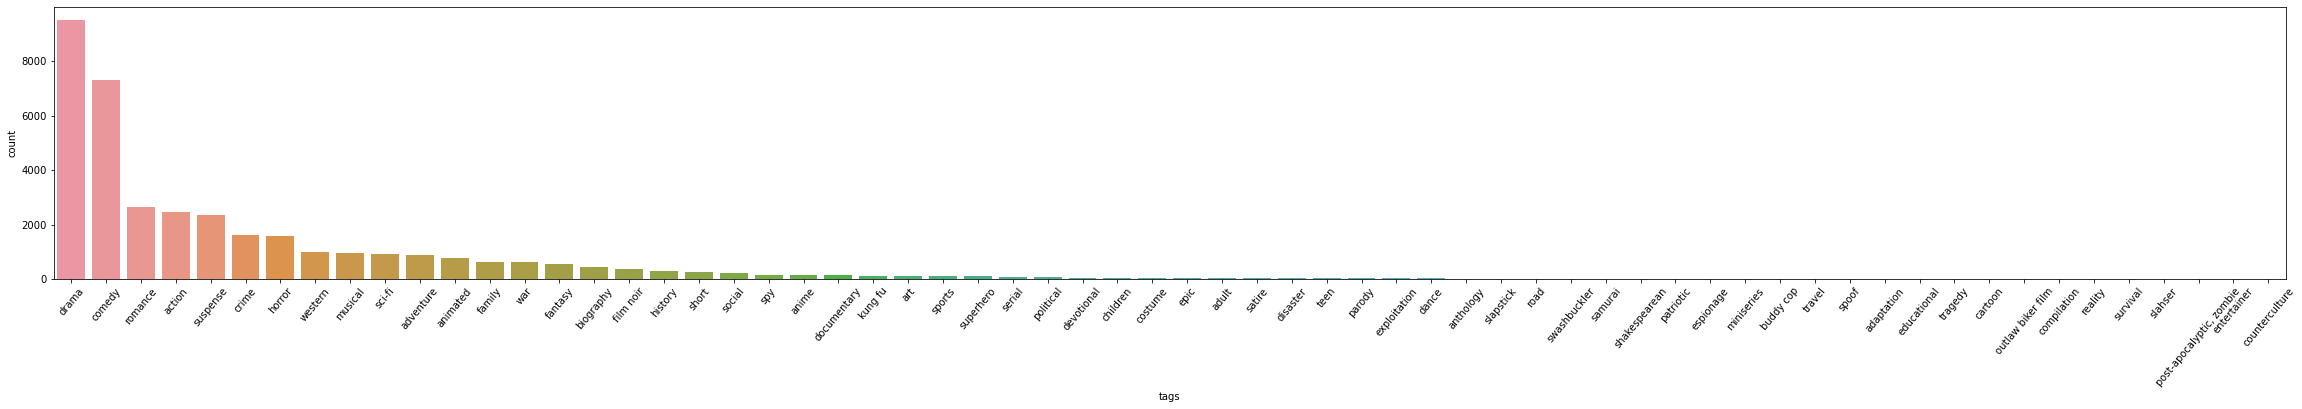

In [52]:
plt.figure(figsize=(40,5))
sns.barplot(x='tags', y="count", data=col_count_per.sort_values('count',ascending=False))
plt.xticks(rotation=50)
plt.show()

In [53]:
col_count_per[col_count_per['tags'] == 'tragedy']

,tags,count,percentage
63,tragedy,3,0.008599


C:\Users\varsh\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

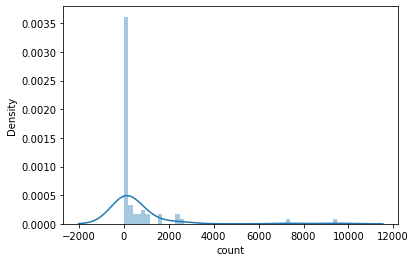

In [54]:
sns.distplot(col_count_per['count'],kde=True)

<AxesSubplot:xlabel='count'>

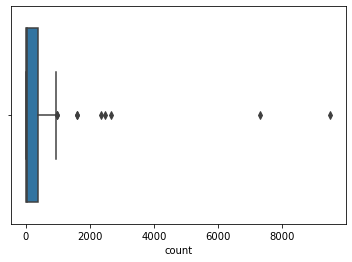

In [55]:
sns.boxplot(x=col_count_per['count'])

<AxesSubplot:>

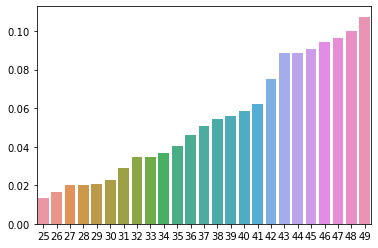

In [56]:
percentiles = [np.percentile(col_count_per['percentage'],q = i) for i in range(25,50,1)]

sns.barplot(x=list(range(25,50,1)),y=percentiles)

<AxesSubplot:>

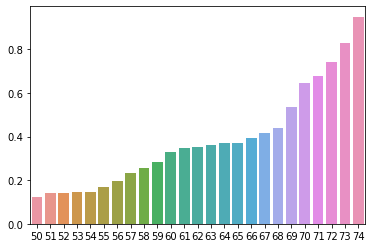

In [57]:
percentiles = [np.percentile(col_count_per['percentage'],q = i) for i in range(50,75,1)]

sns.barplot(x=list(range(50,75,1)),y=percentiles)

<AxesSubplot:>

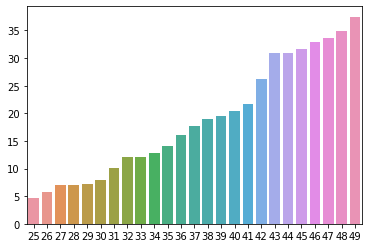

In [58]:
percentiles = [np.percentile(col_count_per['count'],q = i) for i in range(25,50,1)]

sns.barplot(x=list(range(25,50,1)),y=percentiles)

<AxesSubplot:>

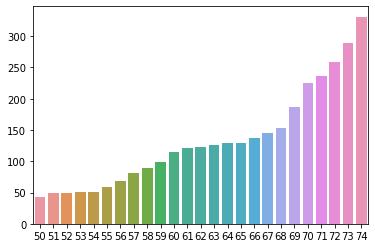

In [59]:
percentiles = [np.percentile(col_count_per['count'],q = i) for i in range(50,75,1)]

sns.barplot(x=list(range(50,75,1)),y=percentiles)

In [60]:
np.percentile(col_count_per['percentage'],20)

0.010319325804047473

In [61]:
np.percentile(col_count_per['percentage'],30)

0.022645187181104164

In [62]:
np.percentile(col_count_per['percentage'],35)

0.04056068336868656

In [63]:
np.percentile(col_count_per['percentage'],40)

0.058476179556269006

In [64]:
np.percentile(col_count_per['percentage'],50)

0.12469185346557357

In [65]:
len(col_count_per[col_count_per['count'] < 50])

33

In [66]:
len(col_count_per[col_count_per['count'] < 100])

38

In [67]:
col_count_per.sort_values('count',ascending=False).head(30)

,tags,count,percentage
4,drama,9508,27.254486
1,comedy,7314,20.965430
3,romance,2647,7.587571
0,action,2464,7.063005
6,suspense,2345,6.721894
25,crime,1607,4.606432
27,horror,1587,4.549103
32,western,974,2.791951
13,musical,967,2.771886
2,sci-fi,931,2.668692


In [68]:
final_tags_list = list(col_count_per[col_count_per['percentage'] >= 1]['tags'])

In [69]:
print(len(final_tags_list))

17


In [70]:
result_tags.shape

(34886, 70)

In [71]:
final_tags = result_tags[seg_cols + final_tags_list]

In [72]:
final_tags.tail(2)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,action,comedy,sci-fi,romance,...,biography,musical,animated,film noir,adventure,crime,war,horror,family,western
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,romantic,The writer Orhan Şahin returns to İstanbul aft...,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
final_tags['Release Year'].nunique()

117

In [74]:
final_tags['Origin/Ethnicity'].nunique()

24

In [75]:
final_tags['Director'].nunique()

12593

In [76]:
final_tags['Release Year'].value_counts()

2013    1021
2014     929
2012     874
2011     858
2010     825
        ... 
1906       3
1905       2
1903       2
1904       1
1902       1
Name: Release Year, Length: 117, dtype: int64

In [77]:
final_tags[final_tags['action'] !=0]['Release Year'].value_counts()

2017    174
2013    136
2016    133
2011    129
2014    124
       ... 
1923      1
1946      1
1950      1
1952      1
1906      1
Name: Release Year, Length: 90, dtype: int64

In [78]:
final_tags[final_tags['action'] !=0]['Release Year'].value_counts().index[0]

2017

In [79]:
yr_top_count = pd.DataFrame()

In [80]:
year =[]
count = []
percentage = []
for col in final_tags_list:
    yr = final_tags[final_tags[col] !=0]['Release Year'].value_counts()
    year.append(yr.index[0])
    count.append(yr[yr.index[0]])
    percentage.append(round((yr[yr.index[0]]/yr.sum())*100,2))

In [81]:
yr_top_count['genre'] = final_tags_list
yr_top_count['year'] = year
yr_top_count['count'] = count
yr_top_count['percentage'] = percentage

In [82]:
yr_top_count

,genre,year,count,percentage
0,action,2017,174,7.06
1,comedy,2013,216,2.95
2,sci-fi,2017,60,6.44
3,romance,2011,138,5.21
4,drama,2011,271,2.85
5,suspense,2013,126,5.37
6,fantasy,2017,60,10.95
7,biography,2017,24,5.26
8,musical,1929,32,3.31
9,animated,1950,26,3.39


In [83]:
ethinicity_top_count = pd.DataFrame()

In [84]:
ethnicity = []
counts = []
percentages = []
for col in final_tags_list:
    ethct = final_tags[final_tags[col] !=0]['Origin/Ethnicity'].value_counts()
    ethnicity.append(ethct.index[0])
    counts.append(ethct[ethct.index[0]])
    percentages.append(round((ethct[ethct.index[0]]/ethct.sum())*100,2))

In [85]:
ethinicity_top_count['genre'] = final_tags_list
ethinicity_top_count['ethnicity'] = ethnicity
ethinicity_top_count['count'] = counts
ethinicity_top_count['percentage'] = percentages

In [86]:
ethinicity_top_count

,genre,ethnicity,count,percentage
0,action,American,825,33.48
1,comedy,American,4707,64.36
2,sci-fi,American,706,75.83
3,romance,American,732,27.65
4,drama,American,5162,54.29
5,suspense,American,1090,46.48
6,fantasy,American,285,52.01
7,biography,American,347,76.10
8,musical,American,710,73.42
9,animated,American,635,82.79


In [87]:
unique_ethnicity = list(final_tags['Origin/Ethnicity'].unique())

In [88]:
ethnicity_df = pd.DataFrame()

In [89]:
ethnicity = []
ethnicity_genre = []
percentage = []

for language in unique_ethnicity:
    
    filter_ethnicity = final_tags[final_tags['Origin/Ethnicity'] == language]
    percentage_genre = 100 * filter_ethnicity[final_tags_list].sum(axis = 0)/len(filter_ethnicity)
    #print(language,percentage_genre)
    
    ethnicity.extend([language]*2)
    

    top_2 = percentage_genre.sort_values(ascending=False)[:2]
    #print(top_2)
    
    ind = top_2.index
    #print(ind)
    ethnicity_genre.append(ind[0])
    ethnicity_genre.append(ind[1])
    
    percentage.append(top_2[ind[0]])
    percentage.append(top_2[ind[1]])


In [90]:
ethnicity_df['ethnicity'] = ethnicity
ethnicity_df['genre'] = ethnicity_genre
ethnicity_df['percentage'] = percentage

In [91]:
ethnicity_df

,ethnicity,genre,percentage
0,American,drama,29.705933
1,American,comedy,27.087529
2,Australian,drama,34.722222
3,Australian,comedy,18.923611
4,Bangladeshi,drama,40.229885
5,Bangladeshi,romance,39.080460
6,British,drama,26.294278
7,British,comedy,24.087193
8,Canadian,drama,53.388658
9,Canadian,comedy,18.672199


In [92]:
# filter_ethnicity = final_tags[final_tags['Origin/Ethnicity'] == 'Maldivian']
# percentage_genre = 100 * filter_ethnicity[final_tags_list].sum(axis = 0)/len(filter_ethnicity)
# percentage_genre.sort_values(ascending=False)

In [93]:
final_tags['Plot']

0        A bartender is working at a saloon, serving dr...
1        The moon, painted with a smiling face hangs ov...
2        The film, just over a minute long, is composed...
3        Lasting just 61 seconds and consisting of two ...
4        The earliest known adaptation of the classic f...
                               ...                        
34881    The film begins in 1919, just after World War ...
34882    Two musicians, Salih and Gürkan, described the...
34883    Zafer, a sailor living with his mother Döndü i...
34884    The film centres around a young woman named Am...
34885    The writer Orhan Şahin returns to İstanbul aft...
Name: Plot, Length: 34886, dtype: object

In [94]:
stopwords_custom= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y']

In [95]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    
    pos_tagged_text = nltk.pos_tag(text.split())
    #print(pos_tagged_text)
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [96]:
def clean_text(sentence):
    sentence = sentence.lower()
                  
    sentence = re.sub(r'\â€˜','',sentence)
    sentence = re.sub(r'\â€™','',sentence) 
    sentence = re.sub(r'\Â£','',sentence)
    sentence = re.sub(r'\Ã©e','',sentence)
    sentence = re.sub(r'[-]+',' ',sentence)        #Replace - with spaces
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords_custom]) 
    sentence = re.sub(r'[^\w\s]','',sentence)           #Remove punctuations (custom punctuations)
    sentence = re.sub(r'[^a-z ]+','',sentence) #Remove numbers
    #sentence = re.sub(r'\\b[a-z]\\b','', sentence)    #
    sentence = re.sub(r'[\s]+', ' ',sentence)        #Replace multiple spaces with spaces
    sentence = lemmatize_words(sentence)            
    
    return sentence

In [97]:
final_tags['clean_plot'] = final_tags['Plot'].apply(clean_text)

C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\246286951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_tags['clean_plot'] = final_tags['Plot'].apply(clean_text)


In [98]:
#final_tags['length'] = final_tags['clean_plot'].apply(lambda row: len(row))

In [99]:
final_tags['length'] = final_tags['clean_plot'].str.len()

C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\3034407693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_tags['length'] = final_tags['clean_plot'].str.len()


In [100]:
final_tags.head(3)

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,action,comedy,sci-fi,romance,...,animated,film noir,adventure,crime,war,horror,family,western,clean_plot,length
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bartender work saloon serve drink customer fil...,321
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moon paint smile face hang park night young co...,245
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,film minute long compose two shot first girl s...,286


In [101]:
# replace non zeros with 1's
temp = final_tags[final_tags_list]
temp[temp != 0] = 1
final_tags[final_tags_list] = temp
final_tags

C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\1223641063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[temp != 0] = 1
C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\1223641063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[temp != 0] = 1
C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\1223641063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,action,comedy,sci-fi,romance,...,animated,film noir,adventure,crime,war,horror,family,western,clean_plot,length
0,1901,Kansas Saloon Smashers,American,Unknown,unknown,"A bartender is working at a saloon, serving dr...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bartender work saloon serve drink customer fil...,321
1,1901,Love by the Light of the Moon,American,Unknown,unknown,"The moon, painted with a smiling face hangs ov...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moon paint smile face hang park night young co...,245
2,1901,The Martyred Presidents,American,Unknown,unknown,"The film, just over a minute long, is composed...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,film minute long compose two shot first girl s...,286
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,unknown,Lasting just 61 seconds and consisting of two ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,last second consist two shot first shot set wo...,573
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",unknown,The earliest known adaptation of the classic f...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early know adaptation classic fairytale film s...,432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,unknown,"The film begins in 1919, just after World War ...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,film begin world war end centre around joshua ...,2292
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,comedy,"Two musicians, Salih and Gürkan, described the...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,two musician salih grkan described adventure c...,51
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,comedy,"Zafer, a sailor living with his mother Döndü i...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,zafer sailor live mother dnd coastal village i...,253
34884,2017,Non-Transferable,Turkish,Brendan Bradley,romantic comedy,The film centres around a young woman named Am...,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,film centre around young woman name amy tyler ...,746


In [102]:
final_tags['suspense'].value_counts()

0.0    32541
1.0     2345
Name: suspense, dtype: int64

In [103]:
np.mean(final_tags['length'])

1413.293355500774

In [104]:
final_tags['clean_plot'][737]

'william steamboat bill canfield owner captain paddle steamer see well day eagerly awaits arrival college student son not see since lad baby expect big husky man like help compete businessman john james king brand new luxurious riverboat sorely disappointed slight awkward offspring show pencil moustache ukulele beret become outraged discovers son king daughter kitty also visit father love business rival determine break relationship canfield ship condemn unsafe accuses king orchestrate it assaults enemy put jail son try free bring loaf bread tool hidden inside scheme detect sheriff hit canfield jr head send hospital cyclone hit tear building endanger ship canfield jr make way town building front fall around him reach father ship rescue first kitty strand float house father by ram ship sinking jail also blow river finally kittys father kitty go hero puzzle jump water however purpose becomes clear return tow minister lifebuoy'

In [105]:
# add = final_tags[final_tags['action']!= 0]['length'].sum(axis = 0)
# l = len(final_tags[final_tags['action']!= 0]['length'])
# add / l 

In [106]:
lengthofgenre = pd.DataFrame()

In [107]:
avg_len = []
for col in final_tags_list:
    sumofcol = final_tags[final_tags[col]!= 0]['length'].sum(axis = 0)
    length = len(final_tags[final_tags[col]!= 0]['length'])
    avg_len.append(sumofcol / length)  

In [108]:
lengthofgenre['genre'] = final_tags_list
lengthofgenre['avg_len'] = avg_len

In [109]:
lengthofgenre

,genre,avg_len
0,action,1727.921266
1,comedy,1406.185535
2,sci-fi,2190.352309
3,romance,1317.228938
4,drama,1336.899558
5,suspense,1641.347974
6,fantasy,2133.919708
7,biography,1718.598684
8,musical,1343.118925
9,animated,2008.966102


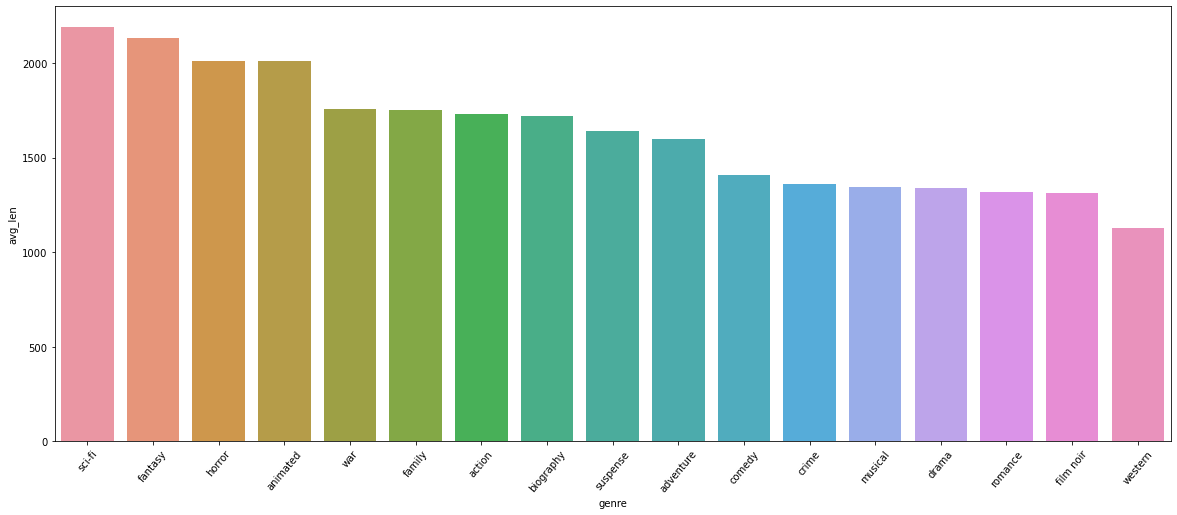

In [110]:
plt.figure(figsize=(20,8))
sns.barplot(x = 'genre', y = "avg_len", data = lengthofgenre.sort_values('avg_len',ascending=False))
plt.xticks(rotation=50)
plt.show()

#### Conclusion: 

In [111]:
new_data = final_tags[['clean_plot','action', 'comedy', 'sci-fi', 'romance', 'drama', 'suspense',
       'fantasy', 'biography', 'musical', 'animated', 'film noir', 'adventure',
       'crime', 'war', 'horror', 'family', 'western']]

In [112]:
new_data.head(3)

,clean_plot,action,comedy,sci-fi,romance,drama,suspense,fantasy,biography,musical,animated,film noir,adventure,crime,war,horror,family,western
0,bartender work saloon serve drink customer fil...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,moon paint smile face hang park night young co...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,film minute long compose two shot first girl s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
new_data['action'].value_counts(normalize=True)

0.0    0.92937
1.0    0.07063
Name: action, dtype: float64

In [114]:
new_data['musical'].value_counts(normalize=True)

0.0    0.972281
1.0    0.027719
Name: musical, dtype: float64

In [115]:
new_tag = ['action', 'comedy', 'sci-fi', 'romance', 'drama', 'suspense',
       'fantasy', 'biography', 'musical', 'animated', 'film noir', 'adventure',
       'crime', 'war', 'horror', 'family', 'western']

In [116]:
df = pd.DataFrame()

In [117]:
lst_0 = []
lst_1 = []
for genre in new_tag:
    val_cnt = new_data[genre].value_counts(normalize=True)
    lst_0.append(val_cnt[0])
    lst_1.append(val_cnt[1])
    

In [118]:
df['genre'] = new_tag
df['0'] = lst_0
df['1'] = lst_1

In [119]:
df['sum'] = df['0'] + df['1']

In [120]:
df['count_1'] = df['1'] * len(new_data)
df.sort_values('1',ascending=False)

,genre,0,1,sum,count_1
4,drama,0.727455,0.272545,1.0,9508.0
1,comedy,0.790346,0.209654,1.0,7314.0
3,romance,0.924124,0.075876,1.0,2647.0
0,action,0.929370,0.070630,1.0,2464.0
5,suspense,0.932781,0.067219,1.0,2345.0
12,crime,0.953936,0.046064,1.0,1607.0
14,horror,0.954509,0.045491,1.0,1587.0
16,western,0.972080,0.027920,1.0,974.0
8,musical,0.972281,0.027719,1.0,967.0
2,sci-fi,0.973313,0.026687,1.0,931.0


#### conclusion

In [121]:
new_data['musical'].value_counts()

0.0    33919
1.0      967
Name: musical, dtype: int64

In [122]:
new_data['suspense'].value_counts()

0.0    32541
1.0     2345
Name: suspense, dtype: int64

### saving clean data

In [123]:
new_data.to_csv("cleaned_movie_plot_data.csv",index = False)

######  reading saved cleaned data

In [124]:
new_data = pd.read_csv("cleaned_movie_plot_data.csv")

In [267]:
new_data.head()

,clean_plot,action,comedy,sci-fi,romance,drama,suspense,fantasy,biography,musical,animated,film noir,adventure,crime,war,horror,family,western
0,bartender work saloon serve drink customer fil...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,moon paint smile face hang park night young co...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,film minute long compose two shot first girl s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,last second consist two shot first shot set wo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,early know adaptation classic fairytale film s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
genre_list = ['action', 'comedy', 'sci-fi', 'romance', 'drama', 'suspense',
       'fantasy', 'biography', 'musical', 'animated', 'film noir', 'adventure',
       'crime', 'war', 'horror', 'family', 'western']

#### Train_test Split

In [126]:
X = new_data['clean_plot']
y = new_data['action']

In [127]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,random_state = 42,stratify = y)

In [128]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [129]:
X_train.shape

(27908,)

In [130]:
X_train_tfidf.shape

(27908, 5000)

In [131]:
y.shape

(34886,)

### Oversampling

In [132]:
sm_over = SMOTE(random_state=42)
X_res_over, y_res_over = sm_over.fit_resample(X_train_tfidf,y_train)

In [133]:
lr = LogisticRegression()
lr.fit(X_res_over, y_res_over)

LogisticRegression()

In [134]:
y_pred_over = lr.predict(X_test_tfidf)

In [135]:
recall_score(y_test,y_pred_over)

0.6125760649087221

In [136]:
f1_score(y_test,y_pred_over)

0.37702871410736577

### Undersampling

In [137]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_tfidf,y_train)

In [138]:
lr_under = LogisticRegression()
lr_under.fit(X_res, y_res)

LogisticRegression()

In [139]:
y_pred_under = lr_under.predict(X_test_tfidf)

In [140]:
recall_score(y_test,y_pred_under)

0.7505070993914807

In [141]:
f1_score(y_test,y_pred_under)

0.32599118942731276

#### Using function

#### F1-score/Recall-score for all the target features

In [142]:
def handle_imbalance(x,y,imb_flag,model):
    
    tfidf = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf.fit_transform(x)
    
    if imb_flag == "over":
        over_smpl = SMOTE(random_state=42)
        X_res, y_res = over_smpl.fit_resample(X_tfidf,y)
    else:
        under_smpl = RandomUnderSampler(random_state=42)
        X_res, y_res = under_smpl.fit_resample(X_tfidf,y)
        
    model.fit(X_res,y_res)
    
    return model,tfidf


In [194]:
 def train_funct(imb_flag,model):
        
    recall_train = []
    recall_test = []
    precision_train = []
    precision_test = []
    f1_train = []
    f1_test = []
    model_tfidf = {}
    
    X = new_data['clean_plot']

    for genre in tqdm(genre_list):
        
        X_train,X_test,y_train,y_test = train_test_split(X,new_data[genre],test_size = .2,random_state = 42,stratify = new_data[genre])

        model_objs,tfidf_pipe =  handle_imbalance(X_train,y_train,imb_flag,model)
        
        model_tfidf[genre] = [model_objs, tfidf_pipe, y_test]
         

        X_train_tfidf = tfidf_pipe.transform(X_train)
        X_test_tfidf = tfidf_pipe.transform(X_test)

        y_pred_train = model_objs.predict(X_train_tfidf)
        y_pred_test = model_objs.predict(X_test_tfidf)

        recall_train.append(recall_score(y_train, y_pred_train))
        recall_test.append(recall_score(y_test, y_pred_test))
        
        precision_train.append(precision_score(y_train, y_pred_train))
        precision_test.append(precision_score(y_test, y_pred_test))

        f1_train.append(f1_score(y_train, y_pred_train))
        f1_test.append(f1_score(y_test, y_pred_test))


    result = pd.DataFrame()
    result['tags'] = genre_list
    
    result['train_recall_score'] = recall_train
    result['test_recall_score'] = recall_test
    
    result['train_precision_score'] = precision_train
    result['test_precision_score'] = precision_test
    
    result['train_f1_score'] = f1_train
    result['test_f1_score'] = f1_test
    
    return result,model_tfidf

    #     y_pred_lst.append(pipe_objs.predict(tfidf_pipe.transform(X_test)))
    #     f1.append(f1_score(y_test,y_pred_pipe))
    #     recall.append(recall_score(y_test,y_pred_pipe))

    #     y_pred_train.append(recall_score(y_train,pipe_objs.predict(tfidf_pipe.transform(X_train))))

In [144]:
MultinomialNB_under,MultinomialNB_under_dict_model_tfidf = train_funct("under",MultinomialNB())
MultinomialNB_under
#df,_ = train_funct("under",MultinomialNB())

100%|██████████| 17/17 [04:31<00:00, 15.96s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.918823,0.860041,0.201850,0.183312,0.330988,0.302210
1,comedy,0.788412,0.759398,0.414689,0.403120,0.543505,0.526665
2,sci-fi,0.970470,0.908602,0.129872,0.122642,0.229087,0.216113
3,romance,0.886213,0.805293,0.187512,0.166797,0.309532,0.276354
4,drama,0.786879,0.727129,0.447410,0.418204,0.570462,0.531004
5,suspense,0.894989,0.786780,0.183197,0.160087,0.304139,0.266042
6,fantasy,0.990868,0.854545,0.058216,0.049841,0.109971,0.094188
7,biography,0.989041,0.890110,0.036387,0.032426,0.070192,0.062572
8,musical,0.925065,0.797927,0.097975,0.084245,0.177184,0.152400
9,animated,0.969055,0.908497,0.131115,0.119518,0.230978,0.211246


In [195]:
MultinomialNB_over,MultinomialNB_over_dict_model_tfidf = train_funct("over",MultinomialNB())
MultinomialNB_over

100%|██████████| 17/17 [11:00<00:00, 38.85s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.844749,0.730223,0.253966,0.213523,0.390524,0.330427
1,comedy,0.763288,0.727956,0.431915,0.415205,0.551665,0.528798
2,sci-fi,0.930201,0.811828,0.248565,0.221408,0.392301,0.347926
3,romance,0.796506,0.699433,0.227297,0.194737,0.353669,0.304652
4,drama,0.758480,0.694006,0.462630,0.431232,0.574716,0.531936
5,suspense,0.829424,0.663113,0.244885,0.199359,0.378129,0.306555
6,fantasy,0.894977,0.536364,0.162117,0.103691,0.274510,0.173785
7,biography,0.953425,0.615385,0.124910,0.078762,0.220882,0.139651
8,musical,0.872093,0.673575,0.178524,0.141151,0.296378,0.233393
9,animated,0.920195,0.777778,0.307902,0.252654,0.461413,0.381410


In [189]:
xgb_under,xgb_under_dict_model_tfidf = train_funct("under",xgboost.XGBClassifier())
xgb_under 

  0%|          | 0/17 [00:00<?, ?it/s]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  6%|▌         | 1/17 [00:29<07:56, 29.77s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 12%|█▏        | 2/17 [01:30<11:59, 47.98s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 18%|█▊        | 3/17 [01:49<08:05, 34.68s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 24%|██▎       | 4/17 [02:17<06:57, 32.13s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▉       | 5/17 [03:32<09:32, 47.70s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 35%|███▌      | 6/17 [04:12<08:15, 45.06s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████      | 7/17 [04:38<06:27, 38.72s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 47%|████▋     | 8/17 [04:59<04:57, 33.03s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 53%|█████▎    | 9/17 [05:19<03:53, 29.15s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▉    | 10/17 [05:38<03:01, 25.90s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 65%|██████▍   | 11/17 [05:55<02:18, 23.00s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████   | 12/17 [06:15<01:50, 22.20s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▋  | 13/17 [06:39<01:31, 22.89s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 82%|████████▏ | 14/17 [06:57<01:03, 21.26s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 88%|████████▊ | 15/17 [07:20<00:43, 21.97s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|█████████▍| 16/17 [07:38<00:20, 20.76s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 17/17 [07:59<00:00, 28.19s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.976662,0.746450,0.252625,0.188815,0.401418,0.301392
1,comedy,0.941036,0.707450,0.529933,0.397924,0.678037,0.509350
2,sci-fi,0.997315,0.887097,0.188579,0.165000,0.317182,0.278246
3,romance,0.978281,0.742911,0.242651,0.180524,0.388852,0.290466
4,drama,0.922430,0.637224,0.555943,0.399341,0.693761,0.490986
5,suspense,0.982409,0.722814,0.219144,0.164244,0.358351,0.267667
6,fantasy,1.000000,0.700000,0.077153,0.056041,0.143254,0.103774
7,biography,1.000000,0.725275,0.050758,0.036384,0.096612,0.069291
8,musical,0.996124,0.704663,0.127649,0.089415,0.226299,0.158693
9,animated,0.998371,0.875817,0.145848,0.126177,0.254515,0.220576


##### Conclusion: 
                f1 score is not good. Recall is good for action,comedy,sci-fi,romance. 
                Recall for fantasy,biography,musical,animated,film noir,adventure,crime,war,family,western,
                and horror for train is getting almost 100% so Its overfit problem.
                

In [190]:
xgb_over,xgb_over_dict_model_tfidf  = train_funct("over",xgboost.XGBClassifier())
xgb_over

  0%|          | 0/17 [00:00<?, ?it/s]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  6%|▌         | 1/17 [06:02<1:36:42, 362.69s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 12%|█▏        | 2/17 [11:28<1:25:12, 340.83s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 18%|█▊        | 3/17 [21:48<1:49:17, 468.42s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 24%|██▎       | 4/17 [27:49<1:32:18, 426.06s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▉       | 5/17 [33:31<1:19:10, 395.84s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 35%|███▌      | 6/17 [46:23<1:36:00, 523.68s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████      | 7/17 [1:03:30<1:54:42, 688.28s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 47%|████▋     | 8/17 [1:16:24<1:47:20, 715.58s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 53%|█████▎    | 9/17 [1:23:12<1:22:35, 619.44s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▉    | 10/17 [1:31:35<1:08:03, 583.34s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 65%|██████▍   | 11/17 [1:45:38<1:06:17, 662.90s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:22:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████   | 12/17 [2:00:10<1:00:32, 726.46s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:36:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▋  | 13/17 [2:07:48<43:00, 645.12s/it]  C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 82%|████████▏ | 14/17 [2:19:07<32:45, 655.24s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 88%|████████▊ | 15/17 [2:31:41<22:50, 685.07s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|█████████▍| 16/17 [2:43:44<11:36, 696.47s/it]C:\Users\varsh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 17/17 [2:55:46<00:00, 620.38s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.666667,0.300203,0.856584,0.398922,0.749786,0.342593
1,comedy,0.684840,0.420369,0.842515,0.541850,0.755539,0.473441
2,sci-fi,0.910067,0.408602,0.968571,0.477987,0.938408,0.440580
3,romance,0.627007,0.270321,0.783019,0.317073,0.696382,0.291837
4,drama,0.641073,0.358570,0.796732,0.484375,0.710476,0.412085
5,suspense,0.732942,0.287846,0.732942,0.306818,0.732942,0.297030
6,fantasy,0.835616,0.136364,0.968254,0.238095,0.897059,0.173410
7,biography,0.863014,0.120879,0.987461,0.244444,0.921053,0.161765
8,musical,0.788114,0.207254,0.931298,0.266667,0.853744,0.233236
9,animated,0.921824,0.483660,0.986063,0.698113,0.952862,0.571429


In [191]:
gb_under,gb_under_dict_model_tfidf = train_funct("under",GradientBoostingClassifier())
gb_under

100%|██████████| 17/17 [18:13<00:00, 64.32s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.802131,0.730223,0.223494,0.198675,0.349585,0.312364
1,comedy,0.799692,0.748462,0.394453,0.363787,0.528313,0.489604
2,sci-fi,0.955705,0.844086,0.208248,0.185579,0.341979,0.304264
3,romance,0.806893,0.746692,0.211431,0.190361,0.335065,0.303379
4,drama,0.736129,0.656151,0.441353,0.398849,0.551843,0.496124
5,suspense,0.804371,0.707889,0.197461,0.173278,0.317083,0.278407
6,fantasy,0.956621,0.736364,0.094518,0.077960,0.172039,0.140992
7,biography,0.983562,0.725275,0.055282,0.040816,0.104680,0.077283
8,musical,0.895349,0.678756,0.133372,0.099924,0.232161,0.174202
9,animated,0.969055,0.862745,0.163867,0.144105,0.280330,0.246960


In [192]:
gb_over,gb_over_dict_model_tfidf = train_funct("over",GradientBoostingClassifier())
gb_over

100%|██████████| 17/17 [3:01:25<00:00, 640.34s/it]  


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.481481,0.444219,0.339292,0.295946,0.398070,0.355231
1,comedy,0.465561,0.429255,0.496265,0.459064,0.480423,0.443659
2,sci-fi,0.676510,0.575269,0.401274,0.363946,0.503748,0.445833
3,romance,0.481114,0.459357,0.265919,0.247202,0.342521,0.321429
4,drama,0.411254,0.351735,0.500000,0.454793,0.451306,0.396680
5,suspense,0.514925,0.471215,0.259259,0.244740,0.344877,0.322157
6,fantasy,0.561644,0.363636,0.225275,0.161290,0.321569,0.223464
7,biography,0.534247,0.285714,0.173642,0.090278,0.262097,0.137203
8,musical,0.581395,0.430052,0.251397,0.188636,0.351014,0.262243
9,animated,0.667752,0.607843,0.407960,0.359073,0.506485,0.451456


In [193]:
rf_under,rf_under_dict_model_tfidf = train_funct("under",RandomForestClassifier())
rf_under

100%|██████████| 17/17 [10:08<00:00, 35.82s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.999493,0.805274,0.244569,0.189138,0.392978,0.306327
1,comedy,0.998633,0.697881,0.578229,0.400864,0.732389,0.509227
2,sci-fi,1.000000,0.881720,0.167040,0.150459,0.286263,0.257053
3,romance,0.998111,0.741021,0.245471,0.176577,0.394035,0.285195
4,drama,0.995530,0.674027,0.618274,0.417046,0.762807,0.515273
5,suspense,0.998934,0.727079,0.229798,0.171616,0.373642,0.277687
6,fantasy,1.000000,0.727273,0.081884,0.062305,0.151374,0.114778
7,biography,1.000000,0.769231,0.057031,0.044136,0.107908,0.083482
8,musical,0.998708,0.730570,0.160307,0.112710,0.276269,0.195291
9,animated,0.998371,0.862745,0.134548,0.113014,0.237137,0.199849


In [194]:
rf_over,rf_over_dict_model_tfidf = train_funct("over",RandomForestClassifier())
rf_over

100%|██████████| 17/17 [8:24:34<00:00, 1780.85s/it]   


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.985794,0.190669,0.977364,0.410480,0.981561,0.260388
1,comedy,0.995385,0.280930,0.993687,0.501832,0.994536,0.360210
2,sci-fi,0.977181,0.295699,0.979812,0.561224,0.978495,0.387324
3,romance,0.984891,0.141777,0.979803,0.303644,0.982340,0.193299
4,drama,0.987773,0.225552,0.988293,0.467320,0.988033,0.304255
5,suspense,0.995736,0.130064,0.968880,0.291866,0.982124,0.179941
6,fantasy,0.995434,0.063636,0.966741,0.437500,0.980877,0.111111
7,biography,0.989041,0.010989,0.980978,0.250000,0.984993,0.021053
8,musical,0.994832,0.093264,0.985915,0.391304,0.990354,0.150628
9,animated,0.990228,0.215686,0.991843,0.717391,0.991035,0.331658


In [195]:
dt_under,dt_under_dict_model_tfidf = train_funct("under",DecisionTreeClassifier())
dt_under

100%|██████████| 17/17 [08:03<00:00, 28.43s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.997463,0.638945,0.187936,0.120000,0.316281,0.202053
1,comedy,0.998120,0.599453,0.479238,0.287070,0.647558,0.388225
2,sci-fi,1.000000,0.811828,0.124707,0.100266,0.221759,0.178487
3,romance,0.997167,0.587902,0.193886,0.114464,0.324648,0.191620
4,drama,0.992374,0.573081,0.571429,0.328610,0.725246,0.417705
5,suspense,0.997868,0.654584,0.170058,0.111555,0.290593,0.190624
6,fantasy,1.000000,0.672727,0.048132,0.032371,0.091843,0.061770
7,biography,1.000000,0.659341,0.033279,0.021946,0.064414,0.042478
8,musical,0.996124,0.725389,0.087020,0.063091,0.160058,0.116086
9,animated,0.998371,0.810458,0.085174,0.070175,0.156958,0.129167


In [196]:
dt_over,dt_over_dict_model_tfidf = train_funct("over",DecisionTreeClassifier())
dt_over

100%|██████████| 17/17 [55:43<00:00, 196.68s/it] 


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.963978,0.288032,0.998948,0.174233,0.981152,0.217125
1,comedy,0.989574,0.430622,0.999482,0.324241,0.994504,0.369935
2,sci-fi,0.957047,0.413978,1.000000,0.246006,0.978052,0.308617
3,romance,0.965061,0.311909,0.999511,0.174788,0.981984,0.224033
4,drama,0.976597,0.402208,0.999462,0.331743,0.987897,0.363593
5,suspense,0.964286,0.311301,0.999448,0.166098,0.981552,0.216617
6,fantasy,0.961187,0.218182,1.000000,0.097166,0.980210,0.134454
7,biography,0.969863,0.164835,1.000000,0.050505,0.984701,0.077320
8,musical,0.980620,0.238342,1.000000,0.120104,0.990215,0.159722
9,animated,0.983713,0.424837,0.998347,0.211039,0.990976,0.281996


In [198]:
svc_under,svc_under_dict_model_tfidf = train_funct("under",SVC())
svc_under

100%|██████████| 17/17 [1:11:17<00:00, 251.61s/it]


,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score
0,action,0.991882,0.746450,0.279605,0.205817,0.436238,0.322665
1,comedy,0.965476,0.753247,0.558975,0.442038,0.708028,0.557128
2,sci-fi,0.995973,0.784946,0.291781,0.247039,0.451338,0.375804
3,romance,0.982531,0.742911,0.275301,0.204475,0.430092,0.320685
4,drama,0.952932,0.697687,0.596249,0.435940,0.733529,0.536595
5,suspense,0.992004,0.729211,0.239696,0.179716,0.386100,0.288364
6,fantasy,1.000000,0.672727,0.145903,0.103352,0.254651,0.179177
7,biography,1.000000,0.780220,0.066874,0.051749,0.125365,0.097061
8,musical,0.992248,0.683938,0.180876,0.123711,0.305976,0.209524
9,animated,0.995114,0.836601,0.266347,0.224561,0.420220,0.354080


In [146]:
# svc_over,svc_over_dict_model_tfidf = train_funct("over",SVC())
# svc_over

##### Predictions

In [157]:
MultinomialNB_over_dict_model_tfidf

{'action': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'comedy': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'sci-fi': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'romance': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'drama': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'suspense': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'fantasy': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'biography': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'musical': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'animated': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'film noir': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'adventure': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'crime': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'war': [MultinomialNB(), TfidfVectorizer(max_features=5000)],
 'horror': [MultinomialNB(), TfidfVectorizer(max_features=5000)],

In [150]:
def generate_prediction(query_plot):
    final_result = {}
    for key,lst in MultinomialNB_over_dict_model_tfidf.items():
        
        final_result[key] = lst[0].predict(lst[1].transform([query_plot]))[0]
            
    return final_result

In [156]:
row_111 = new_data['clean_plot'][111]
generate_prediction(row_111)

{'action': 0.0,
 'comedy': 0.0,
 'sci-fi': 0.0,
 'romance': 0.0,
 'drama': 0.0,
 'suspense': 0.0,
 'fantasy': 0.0,
 'biography': 0.0,
 'musical': 0.0,
 'animated': 1.0,
 'film noir': 0.0,
 'adventure': 0.0,
 'crime': 0.0,
 'war': 0.0,
 'horror': 0.0,
 'family': 0.0,
 'western': 0.0}

In [152]:
new_data.iloc[111]

clean_plot    don jos officer law seduce gypsy girl carmen o...
action                                                      0.0
comedy                                                      0.0
sci-fi                                                      0.0
romance                                                     0.0
drama                                                       0.0
suspense                                                    0.0
fantasy                                                     0.0
biography                                                   0.0
musical                                                     0.0
animated                                                    0.0
film noir                                                   0.0
adventure                                                   1.0
crime                                                       0.0
war                                                         0.0
horror                                  

In [153]:
new_data.iloc[268]

clean_plot    describe film magazine dr edward meade dexter ...
action                                                      0.0
comedy                                                      0.0
sci-fi                                                      0.0
romance                                                     0.0
drama                                                       1.0
suspense                                                    0.0
fantasy                                                     0.0
biography                                                   0.0
musical                                                     0.0
animated                                                    0.0
film noir                                                   0.0
adventure                                                   0.0
crime                                                       0.0
war                                                         0.0
horror                                  

In [154]:
generate_prediction(new_data['clean_plot'][268])

{'action': 0.0,
 'comedy': 0.0,
 'sci-fi': 0.0,
 'romance': 0.0,
 'drama': 0.0,
 'suspense': 0.0,
 'fantasy': 0.0,
 'biography': 0.0,
 'musical': 0.0,
 'animated': 0.0,
 'film noir': 0.0,
 'adventure': 0.0,
 'crime': 0.0,
 'war': 0.0,
 'horror': 0.0,
 'family': 0.0,
 'western': 0.0}

In [155]:
new_data.iloc[268]['clean_plot']

'describe film magazine dr edward meade dexter close friend richard burton forman rival hand sylvia norcross swanson men volunteer fight war although sylvia favor dr meade proud them edward put uniform head childrens hospital work come convinces true duty lie there surgeon skill need edward resigns commission sylvia disgust perceives cowardice marries richard day leave regiment europe richard conceals hurt devote hospital betty hoyt hawley friend sylvia also hide disappointment feeling richard sylvia us time aid poor family new york low east side come home one night run little girl giraci car turn orphan father die front europe sylvia take child recuperate home learns child may never walk again seek best surgeon sylvia find one not go fight dr meade edward consent best child meanwhile richard front line calmly face possible death wound battle find lose right hand severely injured leave side face ask friend tell wife kill battle back new york sylvia come good understand edward character

#### With diff betas

In [170]:
def score_threshold(model,X_test,y_test,beta):
    
    result = {}
    
    pred_proba = model.predict_proba(X_test)[:,1]
    precisions,recalls,thresholds =  precision_recall_curve(y_test,pred_proba)
    #f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)
#     best_f_beta_score = max(f_beta_scores)
#     ind = np.argmax(f_beta_scores)
#     best_threshold = thresholds[ind]
#     precision_t = precisions[ind]
#     recall_t = recalls[ind]
    
#     result['f_beta_score'] = best_f_beta_score
#     result['threshold'] = best_threshold
#     result['precision'] = precision_t
#     result['recall']  = recall_t
#     result['beta'] = beta
    df = pd.DataFrame()
    df['p'] = precisions[1:]
    df['r'] = recalls[1:]
    df['t'] = thresholds
    df['f_b'] = f_beta_scores[1:]
    
    return df
    

In [ ]:
score_threshold(model,X_test,y_test,beta)

In [262]:
def score_genre_threshold(model,X_test,y_test,beta):
    
#     result = {}
    pred = model.predict(X_test)
    f1score  = f1_score(y_test , pred)
    print(f1score)
    
    pred_proba = model.predict_proba(X_test)[:,1]
    
    precisions,recalls,thresholds =  precision_recall_curve(y_test,pred_proba)
    #f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)
    best_f_beta_score = max(f_beta_scores)
    #print(best_f_beta_score)
    #ind = np.argmax(f_beta_scores)
    ind = np.nanargmax(f_beta_scores)
    #print(ind)
    #print(f_beta_scores[ind])
    
    best_threshold = thresholds[ind]
    
    precision_t = precisions[ind]
    #print(precision_t)
    recall_t = recalls[ind]
    #print(recall_t)
    
    #print(f_beta_scores)
    
#     result['f_beta_score'] = best_f_beta_score
#     result['threshold'] = best_threshold
#     result['precision'] = precision_t
#     result['recall']  = recall_t
#     result['beta'] = beta
    
    
    return best_f_beta_score,precision_t, beta

In [ ]:
dict_genre = MultinomialNB_over_dict_model_tfidf['comedy']
score_df = score_threshold(dict_genre[0],dict_genre[1].transform(X_test),dict_genre[2],0.5)

In [226]:
dict_genre = MultinomialNB_over_dict_model_tfidf['comedy']
score_df = score_threshold(dict_genre[0],dict_genre[1].transform(X_test),dict_genre[2],0.5)

C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\3329441555.py:8: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


In [232]:
score_df[score_df['f_b'] == score_df['f_b'].max()]

,p,r,t,f_b
1302,0.212683,0.822967,0.001553,0.24972


In [240]:
score_df[1300:1310]

,p,r,t,f_b
1300,0.212608,0.822967,0.001550,0.249637
1301,0.212646,0.822967,0.001552,0.249679
1302,0.212683,0.822967,0.001553,0.249720
1303,0.212544,0.822283,0.001553,0.249554
1304,0.212405,0.821599,0.001554,0.249388
1305,0.212443,0.821599,0.001556,0.249429
1306,0.212480,0.821599,0.001556,0.249471
1307,0.212341,0.820916,0.001557,0.249305
1308,0.212378,0.820916,0.001558,0.249346
1309,0.212239,0.820232,0.001558,0.249180


In [264]:
best_f_beta_score = []
precision_t = []
beta = []
for genre in genre_list:
    dict_genre = MultinomialNB_over_dict_model_tfidf[genre]
    best_f_beta_scores,precision_ts, betas = score_genre_threshold(dict_genre[0],dict_genre[1].transform(X_test),dict_genre[2],0.5)
    best_f_beta_score.append(best_f_beta_scores)
    precision_t.append(precision_ts)
    beta.append(betas)
    

0.011214953271028037


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.011976047904191616


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.017857142857142856


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.007117437722419929


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0031201248049922


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.00796812749003984
0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.017094017094017096


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.010638297872340425


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.010582010582010581


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.0


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


0.048939641109298535


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


In [265]:
MultinomialNB_over['f_beta_score'] = best_f_beta_score
MultinomialNB_over['precision_t'] = precision_t
MultinomialNB_over['beta'] = beta

In [266]:
MultinomialNB_over

,tags,train_recall_score,test_recall_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score,f_beta_score,precision_t,beta
0,action,0.844749,0.730223,0.253966,0.213523,0.390524,0.330427,0.086780,0.070651,0.5
1,comedy,0.763288,0.727956,0.431915,0.415205,0.551665,0.528798,0.249720,0.212683,0.5
2,sci-fi,0.930201,0.811828,0.248565,0.221408,0.392301,0.347926,0.035412,0.028622,0.5
3,romance,0.796506,0.699433,0.227297,0.194737,0.353669,0.304652,0.094872,0.077481,0.5
4,drama,0.758480,0.694006,0.462630,0.431232,0.574716,0.531936,0.320238,0.275940,0.5
5,suspense,0.829424,0.663113,0.244885,0.199359,0.378129,0.306555,0.082787,0.067349,0.5
6,fantasy,0.894977,0.536364,0.162117,0.103691,0.274510,0.173785,0.024728,0.020148,0.5
7,biography,0.953425,0.615385,0.124910,0.078762,0.220882,0.139651,0.030303,0.029703,0.5
8,musical,0.872093,0.673575,0.178524,0.141151,0.296378,0.233393,0.035308,0.028520,0.5
9,animated,0.920195,0.777778,0.307902,0.252654,0.461413,0.381410,0.028820,0.023211,0.5


In [258]:
pip install scikit-multilearn

In [263]:
dict_genre = MultinomialNB_over_dict_model_tfidf['comedy']
best_f_beta_score,precision_t, beta = score_genre_threshold(dict_genre[0],dict_genre[1].transform(X_test),dict_genre[2],0.5)

0.011976047904191616


C:\Users\varsh\AppData\Local\Temp\ipykernel_9756\2772630682.py:12: RuntimeWarning: invalid value encountered in true_divide
  f_beta_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


In [238]:
precision_t

0.0

In [206]:
score_df[score_df['f_b'] == score_df['f_b'].max()]

,p,r,t,f_b
1302,0.212683,0.822967,0.001553,0.24972


In [159]:
MultinomialNB_over_dict_model_tfidf['action'][1]

[MultinomialNB(), TfidfVectorizer(max_features=5000)]

In [192]:
y_test

24343    0.0
30003    0.0
1916     0.0
9454     0.0
3478     0.0
        ... 
11811    0.0
19700    0.0
5134     0.0
26175    0.0
6760     0.0
Name: action, Length: 6978, dtype: float64

In [183]:
score_df['t'].describe()

count    6936.000000
mean        0.035075
std         0.078689
min         0.000004
25%         0.002029
50%         0.007696
75%         0.030481
max         0.975133
Name: t, dtype: float64

In [ ]:
def score(X_test,y_test,model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=['not fraud','fraud']).plot()
    plot_precision_recall_curve(model,X_test,y_test)
    

C:\Users\varsh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


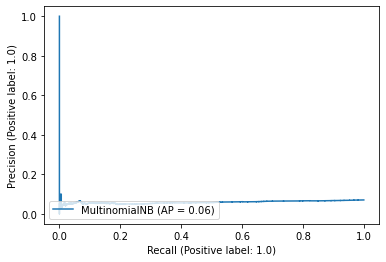

In [187]:
plot_precision_recall_curve(MultinomialNB_over_dict_model_tfidf['action'][0],MultinomialNB_over_dict_model_tfidf['action'][1].transform(X_test),y_test)

In [ ]:
pip install scikit-multilearn

In [ ]:
# parameters = {'lr__C' : [1.0, 0.1, 0.01],
#              }
# param = []
# for p in pipe:
#     grid_pipeline = GridSearchCV(estimator = p, param_grid = parameters,scoring='recall',cv=3)
#     grid = grid_pipeline.fit(X_train,y_train)
#     param.append(grid.best_params_)